In [89]:
import torch
from torch import nn
import os
import pymupdf
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, Gemma3ForCausalLM
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from timeit import default_timer as timer
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, f1_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from PIL import Image
import io
from pathlib import Path

In [90]:
pdf_path = "hr.pdf"
doc = pymupdf.open(pdf_path)


In [91]:
for page in doc:
    text = page.get_text()
    text = text.strip()
    print(text)

RESUME WORLD INC. 
1200 Markham Road, Suite 108, Toronto, Ontario  M1H 3C3 
Tel: (416) 438.3606 / E-mail: info@resumworld.ca  
 
CAREER PROFILE 
A Human Resources & Payroll Manager with over 15 years of progressive experience augmented by a 
strong post-secondary background in Human Resources, Accounting and Business Administration. 
Experienced in Payroll Administration, Benefits/Compensation Administration, Talent/Performance 
Management, Recruitment/Selection, Training/Development, HR Policy and Organizational Design, 
Contract Negotiation, Job Costing Analysis, People Management, Progress Improvement, and 
Strategic Planning.  Sound knowledge of Labour Relations, Occupational Health & Safety, Pay Equity 
and other related labour laws. Proven ability to function as a Strategic HR Business Partner and develop 
and implement successful human resources management strategies to support corporate mandate.  
 
Creative and innovative thinker with effective human resources management and g

In [92]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [93]:
def chatbot_response(pdf_path, device):
    doc = pymupdf.open(pdf_path)
    text = ""
    for page in doc:
        text = page.get_text().strip() + '\n'

    model_id = "google/gemma-3-1b-it"

    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    
    model = Gemma3ForCausalLM.from_pretrained(
        model_id, 
        quantization_config=quantization_config
    ).eval()
    
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    
    prompt = f"""
    Please summarize the candidate's resume succinctly, noting their work experience, skills, projects and education.
    in 5 sentences, Begin without any introduction. 
    The answer is to start with a summary, without a comment like Here's a summary. Highlight his experience, education, 
    projects and write a short summary of this cv like examples:

    Example 1. The person graduated with a 1st degree in computer science, worked as a java developer from 1/12/2023 to 4/07/2024. 
    He is skilled in technologies such as Java, Kotlin, Spring, HTML, CSS. The projects she has done are: 
    Web application for checking stock charts, Website design for a game store.

    Example 2 A person has completed a bachelor's degree in computer science and has not yet worked. 
    She is skilled in technologies such as Python, Pytorch, Numpy, Pandas. The projects she has done are: 
    Image classifier, Housing price analysis.

    Enter the answer for this text: {text}
        """

    messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {
        "role": "user",
        "content": [{"type": "text", "text": prompt}]
    },
]
    
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,  # Tokenizacja od razu
        return_dict=True,
        return_tensors="pt",  # teraz chcemy zwykły tekst, nie tokeny
    ).to(model.device)
    
    #inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.inference_mode():
        outputs = model.generate(**inputs, max_new_tokens=256, temperature=0.7)
    
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    response_only = output_text.split("model\n")[-1].strip()
    print(response_only)

In [94]:
chatbot_response(pdf_path='hr.pdf', device=device)



`low_cpu_mem_usage` was None, now default to True since model is quantized.


Here’s a 5-sentence summary of the candidate’s resume:

Tel: 416)438.3606 / E-mail: info@ResumeWorld.ca                                                www.ResumeWorld.ca
This candidate possesses a strong background in human resources management, demonstrated through experience as an Office Manager and a General Manager. They have a proven track record of optimizing operational efficiency, including cost savings of $750,000 and recovery of $250,000 from chargebacks. Their experience encompasses financial management, accounting, and regulatory compliance, particularly within the banking sector.  The candidate holds a Human Resources Management Diploma from Durham College and an Accounting/Personnel Administration Certificate from York University.  Furthermore, they possess proficiency in Microsoft Office Suite and experience with data tracking and EDI software.


In [95]:
df = pd.read_csv("data/UpdatedResumeDataSet.csv")
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [97]:
df.describe()

,Category,Resume
count,962,962
unique,25,166
top,Java Developer,"Technical Skills Web Technologies: Angular JS,..."
freq,84,18


In [98]:
df.isnull().sum()

Category    0
Resume      0
dtype: int64

In [99]:
df.isna().sum()

Category    0
Resume      0
dtype: int64

In [100]:
df["Resume"] = df["Resume"].str.replace("\r\n", "")


In [101]:
df["Resume"]

0      Skills * Programming Languages: Python (pandas...
1      Education Details May 2013 to May 2017 B.E   U...
2      Areas of Interest Deep Learning, Control Syste...
3      Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4      Education Details  MCA   YMCAUST,  Faridabad, ...
                             ...                        
957    Computer Skills: â¢ Proficient in MS office (...
958    â Willingness to accept the challenges. â ...
959    PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...
960    COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...
961    Skill Set OS Windows XP/7/8/8.1/10 Database MY...
Name: Resume, Length: 962, dtype: object

In [102]:
df["Resume"][1]

'Education Details May 2013 to May 2017 B.E   UIT-RGPVData Scientist Data Scientist - MatelabsSkill Details Python- Exprience - Less than 1 year monthsStatsmodels- Exprience - 12 monthsAWS- Exprience - Less than 1 year monthsMachine learning- Exprience - Less than 1 year monthsSklearn- Exprience - Less than 1 year monthsScipy- Exprience - Less than 1 year monthsKeras- Exprience - Less than 1 year monthsCompany Details company - Matelabsdescription - ML Platform for business professionals, dummies and enthusiasts.60/A Koramangala 5th block,Achievements/Tasks behind sukh sagar, Bengaluru,India                               Developed and deployed auto preprocessing steps of machine learning mainly missing valuetreatment, outlier detection, encoding, scaling, feature selection and dimensionality reduction.Deployed automated classification and regression model.linkedin.com/in/aditya-rathore-b4600b146                           Reasearch and deployed the time series forecasting model ARIMA, S

In [103]:
def clean_text(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', str(text))

df['Resume'] = df['Resume'].apply(clean_text)

In [104]:
nltk.download('punkt_tab')
df['tokens'] = df['Resume'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\piotr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [105]:
df.head()

,Category,Resume,tokens
0,Data Science,Skills Programming Languages Python pandas nu...,"[Skills, Programming, Languages, Python, panda..."
1,Data Science,Education Details May 2013 to May 2017 BE UI...,"[Education, Details, May, 2013, to, May, 2017,..."
2,Data Science,Areas of Interest Deep Learning Control System...,"[Areas, of, Interest, Deep, Learning, Control,..."
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA...,"[Skills, R, Python, SAP, HANA, Tableau, SAP, H..."
4,Data Science,Education Details MCA YMCAUST Faridabad H...,"[Education, Details, MCA, YMCAUST, Faridabad, ..."


In [106]:
model_id = "sentence-transformers/all-mpnet-base-v2"

tokenizer = AutoTokenizer.from_pretrained(model_id)

#tokens_num = tokenizer(df['tokens'], return_tensors="pt")

tokens = tokenizer(
    df['Resume'].tolist(),
    max_length=256,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

In [107]:
df.head()

,Category,Resume,tokens
0,Data Science,Skills Programming Languages Python pandas nu...,"[Skills, Programming, Languages, Python, panda..."
1,Data Science,Education Details May 2013 to May 2017 BE UI...,"[Education, Details, May, 2013, to, May, 2017,..."
2,Data Science,Areas of Interest Deep Learning Control System...,"[Areas, of, Interest, Deep, Learning, Control,..."
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA...,"[Skills, R, Python, SAP, HANA, Tableau, SAP, H..."
4,Data Science,Education Details MCA YMCAUST Faridabad H...,"[Education, Details, MCA, YMCAUST, Faridabad, ..."


In [108]:
label_encoder = preprocessing.LabelEncoder()
df['labels']= label_encoder.fit_transform(df['Category'])

df['labels'].unique()

array([ 6, 12,  0,  1, 24, 16, 22, 14,  5, 15,  4, 21,  2, 11, 18, 20,  8,
       17, 19,  7, 13, 10,  9,  3, 23])

In [109]:
categories = label_encoder.inverse_transform([5, 2, 11, 15, 6])
print(categories)

['Civil Engineer' 'Automation Testing' 'Electrical Engineering'
 'Java Developer' 'Data Science']


In [110]:
tokens['input_ids'].shape

torch.Size([962, 256])

In [111]:
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

# Sentences are encode/embedded by calling model.encode()
embeddings = embedding_model.encode(df['Resume'], convert_to_tensor=True)
# embeddings_dict = dict(zip(sentences, embeddings))
embeddings[:1]

tensor([[ 8.4228e-02,  1.8861e-02, -3.6346e-02, -5.8046e-02, -1.8032e-02,
          2.8797e-02,  2.2757e-02,  3.6112e-02, -2.0567e-02, -7.1827e-02,
          1.8490e-02,  4.5674e-02,  8.5627e-03,  1.3978e-01, -1.7421e-03,
          1.5289e-02,  1.6518e-02,  3.3666e-02,  9.1464e-03,  1.4019e-02,
          2.2316e-02,  3.8016e-02,  3.5120e-03,  2.6931e-02, -9.6653e-03,
          9.4022e-03,  1.3066e-02, -3.2676e-02, -2.0748e-02, -4.8337e-02,
          3.4560e-02,  4.0677e-02, -3.6413e-02,  2.9135e-02,  2.7625e-06,
         -3.5067e-02, -4.2924e-02, -3.2768e-02, -5.7880e-03, -2.0299e-03,
          6.3860e-02, -1.7583e-02,  2.8353e-02,  3.9186e-02, -2.5079e-02,
         -3.9830e-02,  3.5366e-02,  4.6078e-02,  3.9625e-02,  4.0942e-02,
         -1.8585e-02, -1.9904e-02, -4.4734e-02, -2.3840e-02,  1.5127e-02,
         -2.2767e-02, -1.1145e-02,  4.0512e-02,  5.1332e-02, -2.6361e-02,
          2.0879e-02, -9.0303e-03, -2.9564e-02, -5.1741e-02,  5.7647e-02,
          3.8850e-02,  1.1121e-02, -3.

In [112]:
embeddings.shape

torch.Size([962, 768])

In [113]:
df['labels'].values

array([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 22

In [114]:
X, y = embeddings, torch.tensor(df['labels'].values, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [115]:
len(df['labels'].unique())

25

In [116]:
class CV_Classificator(nn.Module):
    def __init__(self, input_layer: int, hidden_layer: int, output_layer: int):
        super().__init__()

        self.seq = nn.Sequential(
            nn.Linear(in_features=input_layer,
                      out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer,
                      out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer,
                      out_features=output_layer)
        )

    def forward(self, x):
        x = self.seq(x)
        return x

model_cv = CV_Classificator(input_layer=768, hidden_layer=256, output_layer=len(df['labels'].unique()))
model_cv.to(device)

CV_Classificator(
  (seq): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=25, bias=True)
  )
)

In [117]:
model_cv.state_dict()

OrderedDict([('seq.0.weight',
              tensor([[-0.0308, -0.0228, -0.0133,  ...,  0.0236,  0.0035, -0.0295],
                      [ 0.0160, -0.0018, -0.0131,  ..., -0.0251,  0.0316,  0.0225],
                      [ 0.0115, -0.0303, -0.0165,  ...,  0.0258,  0.0032,  0.0189],
                      ...,
                      [-0.0066, -0.0096, -0.0133,  ...,  0.0257,  0.0117,  0.0205],
                      [-0.0325, -0.0204,  0.0038,  ..., -0.0008, -0.0006, -0.0327],
                      [-0.0015, -0.0208, -0.0106,  ..., -0.0341, -0.0323, -0.0054]],
                     device='cuda:0')),
             ('seq.0.bias',
              tensor([-0.0048, -0.0004, -0.0177, -0.0298, -0.0308, -0.0129, -0.0322,  0.0171,
                      -0.0133,  0.0180,  0.0119, -0.0121, -0.0230, -0.0231, -0.0328,  0.0002,
                       0.0017,  0.0162, -0.0260,  0.0312, -0.0234, -0.0158, -0.0317,  0.0092,
                       0.0107,  0.0084, -0.0010,  0.0168, -0.0280,  0.0231, -0.0037, -0.

In [118]:
optimizer = torch.optim.Adam(params=model_cv.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [119]:
X_train, y_test

(tensor([[ 4.2879e-02, -2.4244e-02, -4.6312e-02,  ..., -2.0607e-02,
           3.6933e-02, -4.7896e-02],
         [ 4.5271e-02, -1.2550e-02, -1.8823e-02,  ..., -1.5055e-02,
           5.2113e-03, -2.4957e-02],
         [ 1.5502e-02, -4.3949e-02, -3.5588e-02,  ..., -2.0543e-02,
          -1.8905e-02, -1.6541e-02],
         ...,
         [ 3.3245e-02,  1.8955e-03, -3.0713e-02,  ...,  8.7100e-04,
          -1.5379e-02, -4.6952e-02],
         [ 8.4649e-03, -2.9899e-02, -1.4515e-02,  ..., -5.1431e-03,
          -7.8959e-02,  3.7333e-05],
         [ 4.6132e-02,  2.6261e-02, -2.0574e-02,  ..., -1.8100e-02,
          -2.8751e-02, -9.3135e-03]], device='cuda:0'),
 tensor([11,  4,  4, 23, 15, 10,  1, 12, 14,  7,  3, 24, 16, 16, 24, 24, 18, 23,
          3, 15, 13,  6, 10, 17,  5, 11, 22, 15,  4, 13, 17, 22,  2,  3,  8,  8,
          8, 20, 16, 23, 23, 14,  3, 16,  6,  9, 18, 17, 15,  4,  6, 17, 12, 15,
         15, 23,  4, 15, 15, 21, 19, 13, 10, 24,  5, 15,  1,  3,  3, 15,  3, 21,
         23, 

In [120]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [121]:
def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [122]:
y_train.dtype

torch.int64

In [123]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []

train_time_start = timer()

epochs = 100

for epoch in tqdm(range(epochs)):
    model_cv.train()

    y_train = y_train.long()

    y_logits = model_cv(X_train)
    y_pred = torch.argmax(y_logits, dim=1)

    train_loss = loss_fn(y_logits, y_train)

    train_acc = accuracy_function(y_true=y_train, 
                                  y_pred=y_pred)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_cv.eval()
    with torch.inference_mode():

        test_logits = model_cv(X_test)
        test_pred = torch.argmax(test_logits, dim=1)

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_function(y_true=y_test, 
                                    y_pred=test_pred)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch: {epoch} | train_loss: {train_loss}, train_accuracy: {train_acc} | test_loss: {test_loss}, test_accuracy: {test_acc}")

train_time_end = timer()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 3.2189834117889404, train_accuracy: 3.901170351105332 | test_loss: 3.212947130203247, test_accuracy: 8.290155440414509
Epoch: 1 | train_loss: 3.2117490768432617, train_accuracy: 7.542262678803641 | test_loss: 3.206326723098755, test_accuracy: 13.989637305699482
Epoch: 2 | train_loss: 3.204702854156494, train_accuracy: 14.824447334200261 | test_loss: 3.198850631713867, test_accuracy: 12.953367875647666
Epoch: 3 | train_loss: 3.196897029876709, train_accuracy: 15.344603381014304 | test_loss: 3.1902573108673096, test_accuracy: 12.953367875647666
Epoch: 4 | train_loss: 3.1881144046783447, train_accuracy: 15.084525357607282 | test_loss: 3.180576801300049, test_accuracy: 14.507772020725387
Epoch: 5 | train_loss: 3.178280830383301, train_accuracy: 15.604681404421328 | test_loss: 3.1696460247039795, test_accuracy: 18.134715025906736
Epoch: 6 | train_loss: 3.1671979427337646, train_accuracy: 17.815344603381014 | test_loss: 3.157031774520874, test_accuracy: 23.316062176165

In [124]:
train_losses


[tensor(3.2190, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.2117, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.2047, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.1969, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.1881, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.1783, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.1672, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.1544, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.1395, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.1225, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.1033, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.0818, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.0582, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.0326, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.0052, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.9764, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [125]:
train_losses_float = [loss.item() for loss in train_losses]
test_losses_float = [loss.item() for loss in test_losses]

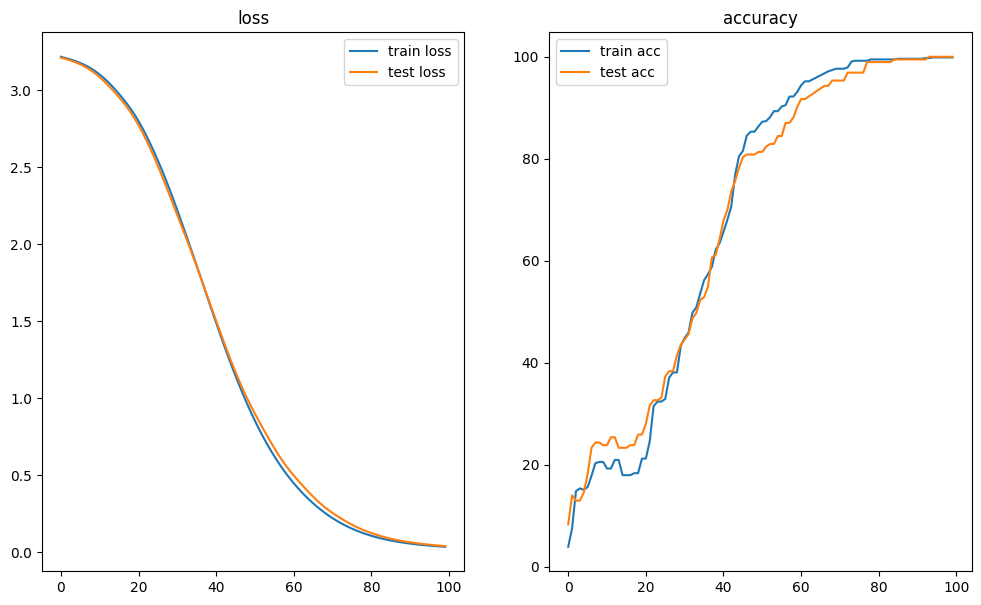

In [126]:
plt.figure(figsize=(12,7))
plt.subplot(1, 2, 1)
plt.title("loss")
plt.plot(train_losses_float, label="train loss")
plt.plot(test_losses_float, label="test loss")
plt.legend()
plt.subplot(1,2,2)
plt.title("accuracy")
plt.plot(train_accs, label="train acc")
plt.plot(test_accs, label="test acc")
plt.legend()

In [127]:
pdf_path = "hr.pdf"
doc = pymupdf.open(pdf_path)
for page in doc:
    text = page.get_text()
    text = text.strip()
    #print(text)

In [128]:
text

'Tel: 416)438.3606 / E-mail: info@ResumeWorld.ca                                                www.ResumeWorld.ca  \n \nAccomplishments \n• \nWorked directly with the President to redesign the company’s HR  Strategy and Payroll Function to \nsupport 1,710 salaried and hourly employees \n• \nCreated a job costing model from a manual costing system by analyzing all functions of costing \nand developing a system to track, monitor and cost all stages of production, resulting in cost \nsavings of $750,000 and recovery of $250,000 from charge back claims for product deficiencies  \n• \nContributed to a work environment that promoted innovation and peak performance by integrating \nhigh-performance expectations into everyday business practices and using HR policies to support \nthe organization’s core values and competencies \n• \nOptimized administrative procedures by sourcing, procuring and implementing automated time \nand attendance system resulting in 23% process improvement \n \nOSCARD

In [129]:
re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
text.replace("\n", "")


'Tel: 416)438.3606 / E-mail: info@ResumeWorld.ca                                                www.ResumeWorld.ca   Accomplishments • Worked directly with the President to redesign the company’s HR  Strategy and Payroll Function to support 1,710 salaried and hourly employees • Created a job costing model from a manual costing system by analyzing all functions of costing and developing a system to track, monitor and cost all stages of production, resulting in cost savings of $750,000 and recovery of $250,000 from charge back claims for product deficiencies  • Contributed to a work environment that promoted innovation and peak performance by integrating high-performance expectations into everyday business practices and using HR policies to support the organization’s core values and competencies • Optimized administrative procedures by sourcing, procuring and implementing automated time and attendance system resulting in 23% process improvement  OSCARDO INC., Toronto, Ontario 1998 - 2000

In [130]:
text_embeddings = embedding_model.encode(text, convert_to_tensor=True)

In [131]:
with torch.inference_mode():
    test_logits = model_cv(text_embeddings)
    test_pred = torch.argmax(test_logits, dim=0)

predicted_index = test_pred.item()
print("Predykcja (numer klasy):", test_pred.item())

Predykcja (numer klasy): 18


In [132]:
categories = label_encoder.inverse_transform([predicted_index])
print(categories)

['Operations Manager']


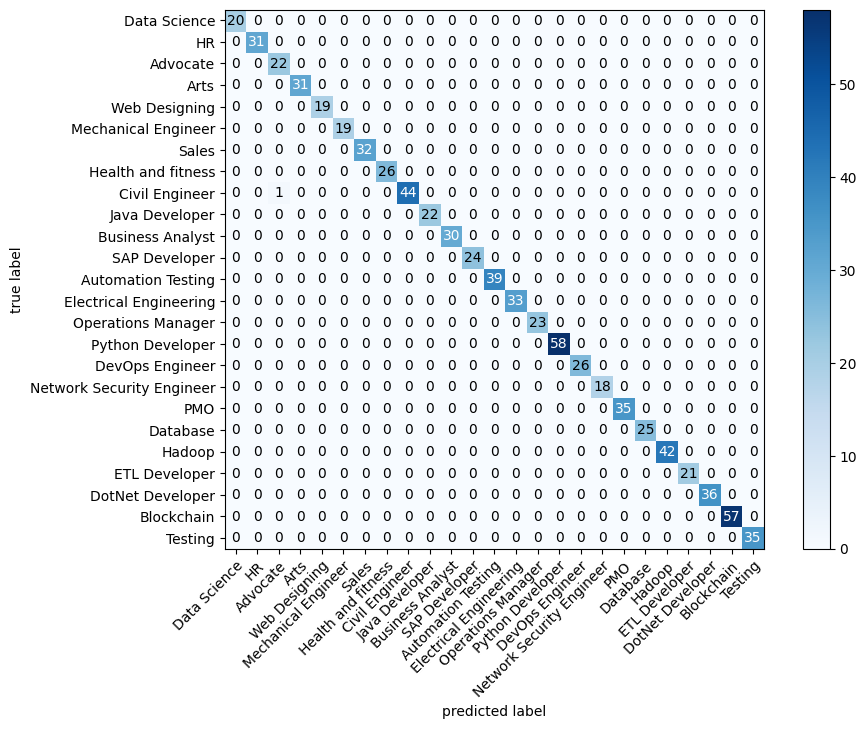

In [133]:
conf_matrix = confusion_matrix(y_true=y_train.cpu(), y_pred=y_pred.cpu())

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, # matplotlib likes working with numpy
                                colorbar=True,
                                #show_absolute=False,
                                #show_normed=True,
                                class_names=df['Category'].unique(),
                                figsize=(10, 7))
plt.show()

In [134]:
accuracy_score(y_true=y_train.cpu(), y_pred=y_pred.cpu())

0.9986996098829649

In [135]:
def get_cv(pdf_path, model):

    #Open pdf file and read as text
    doc = pymupdf.open(pdf_path)
    for page in doc:
        text = page.get_text()
        text = text.strip()
        pix = page.get_pixmap()
        img = Image.open(io.BytesIO(pix.tobytes("png")))
        plt.figure(figsize=(12,6))
        plt.imshow(img)
        plt.axis(False)
        
    
    # Delete reduntant characters
    re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text.replace("\n", "")
    text.replace("\r\n", "")

    # Get embeddings as tensors
    text_embeddings = embedding_model.encode(text, convert_to_tensor=True)

    # Model prediction
    with torch.inference_mode():
        test_logits = model(text_embeddings)
        test_pred = torch.argmax(test_logits, dim=0)

    predicted_index = test_pred.item()
    #print("Predykcja (numer klasy):", test_pred.item())

    categories = label_encoder.inverse_transform([predicted_index])


    
    return categories


array(['Operations Manager'], dtype=object)

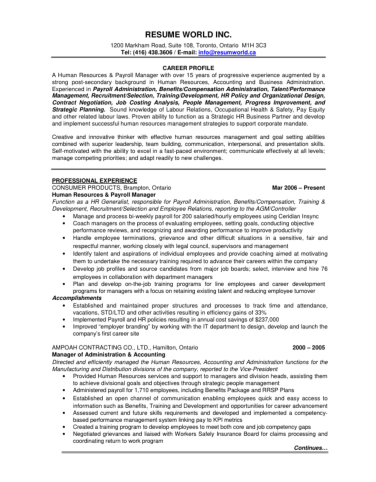

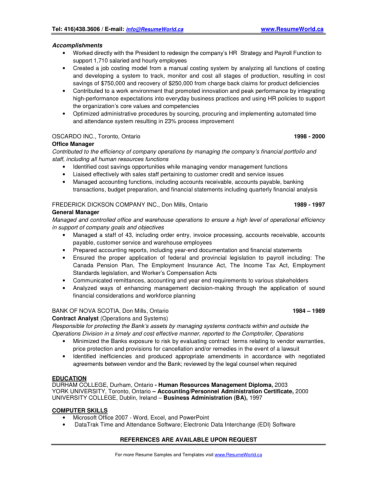

In [136]:
get_cv(pdf_path="hr.pdf", model=model_cv)

In [137]:
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "CV_checker.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
if MODEL_SAVE_PATH.exists():
    print(f"Model already exist: {MODEL_SAVE_PATH}")
else:
    print(f"Save model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model_cv.state_dict(), f=MODEL_SAVE_PATH)

Model already exist: models\CV_checker.pth
